# Spotify Data Clustering Using K-Means

## 01 Importing Libraries and Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os 
import sklearn
from sklearn.cluster import KMeans
import pylab as pl
%matplotlib inline 

In [2]:
path = '/Users/brookecoffey/Desktop/DataAnalyticsTy/Achievement 6 /Spotify Project'

In [3]:
df = pd.read_pickle(os.path.join(path, '01 Data', '02 Prepared Data', 'df_6.pkl'))

In [4]:
df.shape

(172116, 28)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 172116 entries, 0 to 173284
Data columns (total 28 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   ts                                 172116 non-null  datetime64[ns]
 1   platform                           172116 non-null  object        
 2   ms_played                          172116 non-null  int64         
 3   conn_country                       172116 non-null  object        
 4   master_metadata_track_name         169482 non-null  object        
 5   master_metadata_album_artist_name  169482 non-null  object        
 6   master_metadata_album_album_name   169482 non-null  object        
 7   spotify_track_uri                  169482 non-null  object        
 8   episode_name                       1967 non-null    object        
 9   episode_show_name                  1967 non-null    object        
 10  spotify_episode_uri 

In [6]:
df.head()

,ts,platform,ms_played,conn_country,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,episode_name,episode_show_name,...,region,minutes_seconds,year,month,day_of_week,hour_of_day,skipped_ratio,skip_prob,count_y,listening_frequency
0,2012-07-17 02:48:23,"iOS 5.1.1 (iPod4,1)",231177,US,It's Time,Imagine Dragons,Continued Silence EP,spotify:track:40xtweuHBkLXNMO3xCK5AZ,NaN,NaN,...,Pennsylvania,03:51,2012,7,1,2,inf,very likely to be skipped,3.0,Low Frequency
1,2012-07-17 22:26:20,"iOS 5.1.1 (iPod4,1)",25727,US,Jump (feat. Nelly Furtado),Flo Rida,R.O.O.T.S. (Route of Overcoming the Struggle),spotify:track:4uGucgzv0ydi35DgAlsTQ4,NaN,NaN,...,Pennsylvania,00:25,2012,7,1,22,NaN,fwdbtn,1.0,Only Played Once
2,2012-07-17 22:26:23,"iOS 5.1.1 (iPod4,1)",3436,US,I Know You Want Me (Calle Ocho),Pitbull,Pitbull Starring In Rebelution,spotify:track:5RzFJd6W40SDTyZkX6xx45,NaN,NaN,...,Pennsylvania,00:03,2012,7,1,22,2.0,very likely to be skipped,5.0,Low Frequency
3,2012-07-17 22:26:24,"iOS 5.1.1 (iPod4,1)",1532,US,Over And Over,Nelly,6 Pack,spotify:track:2Gfr96HuhYqGcteLv9XUJP,NaN,NaN,...,Pennsylvania,00:01,2012,7,1,22,NaN,fwdbtn,1.0,Only Played Once
4,2012-07-17 22:26:26,"iOS 5.1.1 (iPod4,1)",1486,US,Pause,Pitbull,Planet Pit (Deluxe Version),spotify:track:0c7wqpBLOTFr1yb70LHGFM,NaN,NaN,...,Pennsylvania,00:01,2012,7,1,22,NaN,fwdbtn,1.0,Only Played Once


In [7]:
df.columns

Index(['ts', 'platform', 'ms_played', 'conn_country',
       'master_metadata_track_name', 'master_metadata_album_artist_name',
       'master_metadata_album_album_name', 'spotify_track_uri', 'episode_name',
       'episode_show_name', 'spotify_episode_uri', 'reason_start',
       'reason_end', 'shuffle', 'skipped_x', 'offline', 'latitude',
       'longitude', 'region', 'minutes_seconds', 'year', 'month',
       'day_of_week', 'hour_of_day', 'skipped_ratio', 'skip_prob', 'count_y',
       'listening_frequency'],
      dtype='object')

## 02 Removing Categorical Data 

In [8]:
df = df.drop(columns = ['platform','conn_country',
       'master_metadata_track_name', 'master_metadata_album_artist_name',
       'master_metadata_album_album_name', 'spotify_track_uri', 'episode_name',
       'episode_show_name', 'spotify_episode_uri', 'reason_start',
       'reason_end', 'shuffle', 'skipped_x', 'offline', 'latitude',
       'longitude', 'region', 'minutes_seconds', 'year', 'month',
       'day_of_week', 'hour_of_day','skip_prob','listening_frequency'], axis=1)

In [9]:
df.shape

(172116, 4)

In [10]:
# Dropping timestamp as datetime format won't work with Kmeans
df = df.drop(columns = 'ts')

In [11]:
# Dropping null values 
df.isnull().sum()

ms_played            0
skipped_ratio    17511
count_y           2634
dtype: int64

In [12]:
# Setting infinity values as Null to work with KMeans
pd.set_option('use_inf_as_na',True)

In [13]:
df.dropna(inplace=True)

In [14]:
df.shape

(149631, 3)

In [15]:
# removing extreme values to make more organic clusters
df = df.drop(df[df['count_y'] > 300].index)

In [16]:
df.shape

(148750, 3)

In [17]:
df.head()

,ms_played,skipped_ratio,count_y
2,3436,2.000000,5.0
7,0,0.333333,4.0
11,0,2.000000,3.0
16,240466,0.375000,30.0
17,57771,0.166667,8.0


## 03 Applying Elbow Technique to Determine Number of Clusters

In [18]:
num_cl = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in num_cl]

In [19]:
score = [kmeans[i].fit(df).score(df) for i in range(len(kmeans))]

score

/Users/brookecoffey/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/brookecoffey/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/brookecoffey/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/brookecoffey/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

[-4520210860046271.0,
 -2498575654462360.0,
 -743544068302284.9,
 -434840319737280.8,
 -292571481327319.6,
 -214408742316799.8,
 -164347670557428.4,
 -120029577051160.08,
 -94768587092858.1]

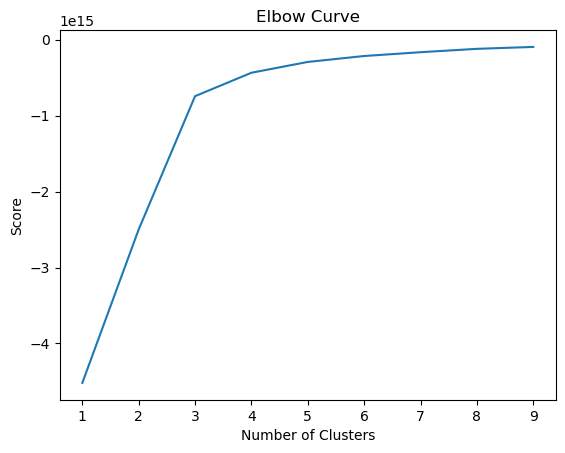

In [20]:
# plotting the elbow curve using PyLab.
pl.plot(num_cl, score)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

###  Based on the output above, it seems that the ideal number of clusters is 4, as that's where the curve straightens out

## 04 KMeans Clustering 

In [21]:
# Create the kmeans object. 
kmeans = KMeans(n_clusters = 4)

In [22]:
kmeans.fit(df)

/Users/brookecoffey/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=4)

In [23]:
df['clusters'] = kmeans.fit_predict(df)

/Users/brookecoffey/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [24]:
df.head()

,ms_played,skipped_ratio,count_y,clusters
2,3436,2.000000,5.0,0
7,0,0.333333,4.0,0
11,0,2.000000,3.0,0
16,240466,0.375000,30.0,2
17,57771,0.166667,8.0,0


In [25]:
df['clusters'].value_counts()

0    72738
2    61557
3    14435
1       20
Name: clusters, dtype: int64

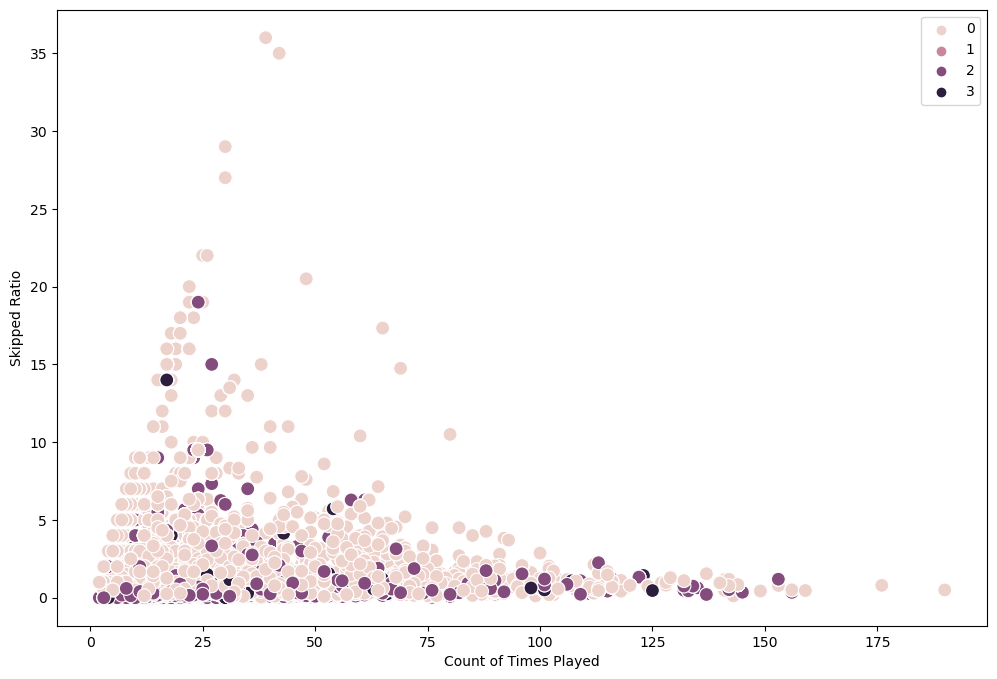

In [26]:
plt.figure(figsize=(12,8))
ax = sns.scatterplot(x=df['count_y'], y=df['skipped_ratio'], hue=kmeans.labels_, s=100)

ax.grid(False)
plt.xlabel('Count of Times Played')
plt.ylabel('Skipped Ratio')
plt.show()

### Plotting count of times played against skipped ratio doesn't seem to show unified clusters as we can see of the wide variety of data points that are shown to be in the same cluster.  I should look at other relationships to determine associations

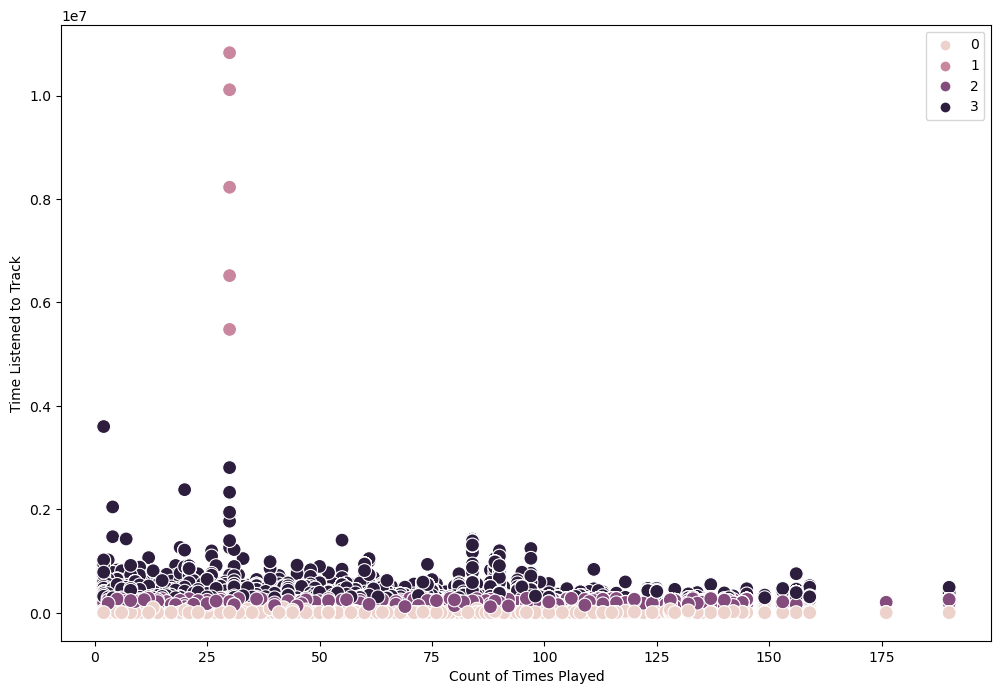

In [27]:
plt.figure(figsize=(12,8))
ax = sns.scatterplot(x=df['count_y'], y=df['ms_played'], hue=kmeans.labels_, s=100)

ax.grid(False)
plt.xlabel('Count of Times Played')
plt.ylabel('Time Listened to Track')
plt.show()

### Plotting count of times played against the total time listened per track looks to be more organized.  We can see clusters grouped around different listening durations, which implies that tracks can be grouped based on how long they are (i.e. short plays, medium plays, medium long plays, and long plays).

In [28]:
df.loc[df['clusters'] == 3, 'cluster'] = 'black'
df.loc[df['clusters'] == 2, 'cluster'] = 'purple'
df.loc[df['clusters'] == 1, 'cluster'] = 'pink'
df.loc[df['clusters'] == 0, 'cluster'] = 'light pink'

In [29]:
df.groupby('cluster').agg({'count_y':['mean', 'median'], 
                         'ms_played':['mean', 'median'], 
                         'skipped_ratio':['mean', 'median']})

count_y            ms_played             skipped_ratio          
                 mean median          mean      median          mean    median
cluster                                                                       
black       43.566747   36.0  3.646673e+05    324420.0      0.911975  0.615385
light pink  44.835574   38.0  1.403018e+04      1877.0      1.791304  1.086957
pink        30.000000   30.0  1.017932e+07  10828190.0      0.000000  0.000000
purple      43.259743   35.0  1.991970e+05    201071.0      0.858725  0.568182

### As discussed above, the largest variance among groups seems to be in the ms_played category.  As I mentioned in my response above, this can be used to categorize tracks based on listening duration, and those categories can be analyzed using other methods to identify any differences among those categories.